# Supernova distances and redshift

Measuring the cosmological relationship between distance and redshift is a crucial task in cosmology. We can use **Standard Candle**, i.e. astrophysical objects with a known brightness. At high redshift we use **Type Ia Supernovae**, a type of supernova produced in the merger od two white dwarfs.

The apparent magnitude $m$ of an astronomical source in a photometric bandpass is defined to be the ratio of the apparent flux of that source to the apparent flux of the bright star Vega, through that bandpass.

The **distance modulus** $\mu$ is defined by:

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

where $ d_{L}$ is the luminosity distance. 


In [1]:
import numpy as np
import pylab as plt
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7, 6]
plt.rcParams['font.size'] = 15

(35.0, 50.0)

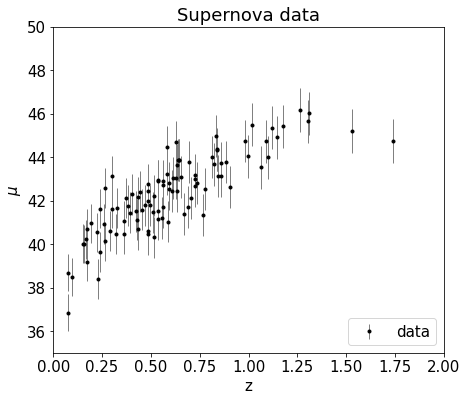

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.title('Supernova data')
plt.xlim(0,2)
plt.ylim(35,50)

Our goal is to fit this data.

## Linear regression

Text(0, 0.5, 'dmu')

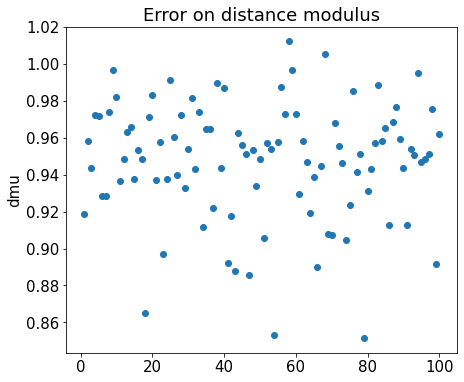

In [3]:
plt.scatter(np.arange(1, len(dmu)+1), dmu)
plt.title('Error on distance modulus')
plt.ylabel('dmu')

We see the errors are heteroscedatic. Let's use **astroML.linear_model.LinearRegression** to take into account errors.

In [4]:
from astroML.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(z_sample[:, np.newaxis], mu_sample, dmu)

print('Coefficients of the regression:' ,lin_reg.coef_)

Coefficients of the regression: [39.48384602  4.76438865]


C:\Users\LEONARDO\anaconda3\lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


(35.0, 50.0)

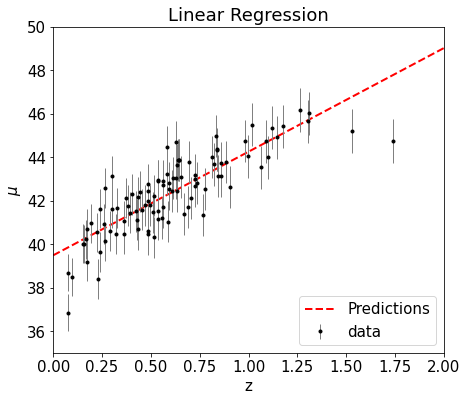

In [5]:
z_grid = np.linspace(0,2,1000)

plt.plot(z_grid, lin_reg.predict(z_grid[:, np.newaxis]), "r--", linewidth=2, label="Predictions")

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Linear Regression')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

## Polynomial regression

Now we perform a polynomial regression, let's start with a third degree polynomial.

In [6]:
from astroML.linear_model import PolynomialRegression

degree = 3
pol_reg = PolynomialRegression(degree) # fit 3rd degree polynomial
pol_reg.fit(z_sample[:, np.newaxis], mu_sample, dmu)

print('Coefficients of the regression:' , pol_reg.coef_)

Coefficients of the regression: [38.36452837  8.87820312 -3.06677777  0.17557977]


(35.0, 50.0)

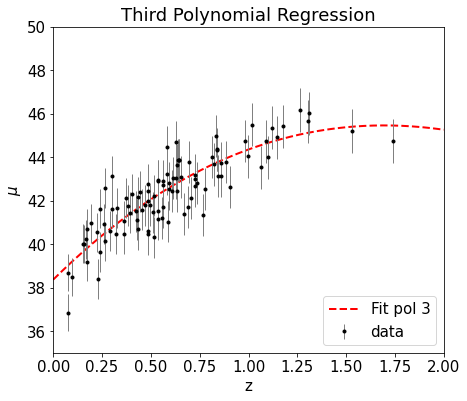

In [7]:
z_grid = np.linspace(0,2,1000)
mu_pred_pol = pol_reg.predict(z_grid[:, np.newaxis])
plt.plot(z_grid, mu_pred_pol, "r--", linewidth=2, label="Fit pol 3")

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Third Polynomial Regression')
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

Doing now regression for polynomials with different degrees.

(35.0, 50.0)

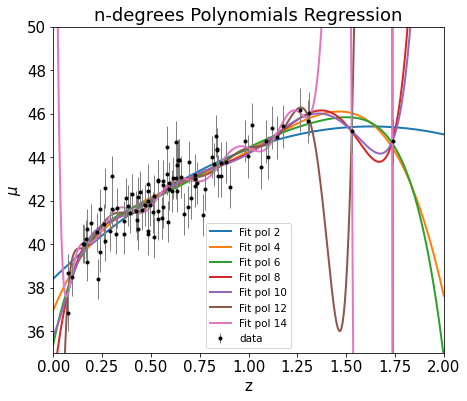

In [8]:
degree = np.arange(2, 16, 2) # from 2 to 14, with a step of two

for i in degree: 
    pol_reg = PolynomialRegression(i) # fit i-rd degree polynomial
    pol_reg.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    mu_pred_pol = pol_reg.predict(z_grid[:, np.newaxis])
    plt.plot(z_grid, mu_pred_pol , linewidth=2, label="Fit pol " +str(i))

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('n-degrees Polynomials Regression')
plt.legend(loc='lower center', fontsize = 'x-small')
plt.xlim(0,2)
plt.ylim(35,50)


By intuition the best is the 6-th degree polynomial.

Below (degree < 6) I'm underfitting, meaning the estimated parameters deviate significantly from the true model parameters.

Above (degree >>6) I'm overfitting the data, meaning these models have high variance and a small change in the training set will result in a significantly change of the model.

## Cross-Validation

Doing Cross-Validation we split our set of data into a **training** set and into a **validation** set. With the first one we learn the **model parameters**, in this case the polynomial coefficients, and with the second set we learn the **hyperparameters**, i.e. the degree of the polynomial.

We perform a K-fold Cross-validation, so each point is treated both as training or cross-validation point at some stages.

We use GridSearchCV from skelearn. Just few comments on the way we are using it.

1. **cv** = Determines the cross-validation splitting strategy, 5 is default.

2. **param_grid** = Dictionary with parameters names (str) as keys and lists of parameter settings to try as values.

3. **scoring** = Strategy to evaluate the performance of the cross-validated model on the test set. All scorer objects follow the convention that higher return values are better than lower return values. Thus metrics which measure the distance between the model and the data, like metrics.mean_squared_error, are available as neg_mean_squared_error which return the negated value of the metric. (negated so we can continue to follow the aforementioned convention.

4. **return_train_score** =  Computing training scores is used to get insights on how different parameter settings impact the overfitting/underfitting trade-off. However computing the scores on the training set can be computationally expensive and is not strictly required to select the parameters that yield the best generalization performance.

In [9]:
from sklearn.model_selection import GridSearchCV

degree = np.arange(1, 16)
K = len(z_sample)
param_grid = {'degree': degree} 

GS = GridSearchCV(PolynomialRegression(), param_grid, scoring = 'neg_root_mean_squared_error', cv= K, return_train_score = True)
GS.fit(z_sample[:,np.newaxis], mu_sample)

optimal_n = GS.best_params_['degree']
print('Optimal parameter with Leave one out cross validation: ', optimal_n)
print(GS.best_estimator_)


Optimal parameter with Leave one out cross validation:  7
PolynomialRegression(degree=7)


(35.0, 50.0)

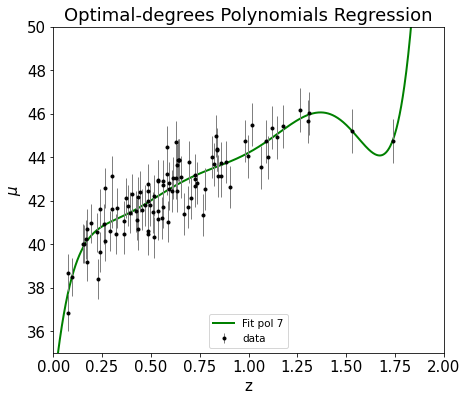

In [10]:
pol_reg = PolynomialRegression(optimal_n) 
pol_reg.fit(z_sample[:, np.newaxis], mu_sample, dmu)
mu_pred_pol = pol_reg.predict(z_grid[:, np.newaxis])
plt.plot(z_grid, mu_pred_pol , linewidth=2, label="Fit pol " +str(optimal_n), color = 'green')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Optimal-degrees Polynomials Regression')
plt.legend(loc='lower center', fontsize = 'x-small')
plt.xlim(0,2)
plt.ylim(35,50)


These seems quite incorrect, even though we used Leave-one-out Cross Validation. I suppose that having few points at high redshift is causing some trouble. In the Leave-one-out procedure the two point at high redshift would end up in the validation set.

In [11]:
from sklearn.model_selection import KFold

K = KFold(n_splits = 10, shuffle=True, random_state=1)
param_grid = {'degree': degree} 

GS = GridSearchCV(PolynomialRegression(), param_grid, scoring = 'neg_root_mean_squared_error', cv= K, return_train_score = True)
GS.fit(z_sample[:,np.newaxis], mu_sample)

optimal_n = GS.best_params_['degree']
print('Optimal parameter with Leave one out cross validation: ', optimal_n)
print(GS.best_estimator_)


Optimal parameter with Leave one out cross validation:  5
PolynomialRegression(degree=5)


(35.0, 50.0)

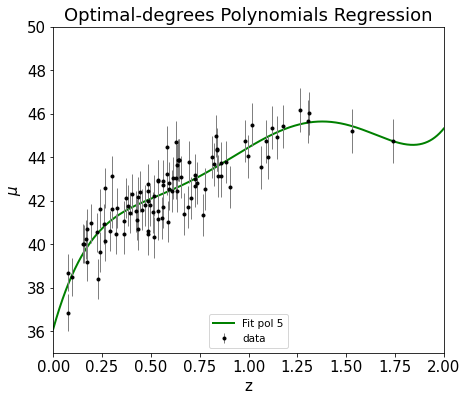

In [12]:
pol_reg = PolynomialRegression(optimal_n) 
pol_reg.fit(z_sample[:, np.newaxis], mu_sample, dmu)
mu_pred_pol = pol_reg.predict(z_grid[:, np.newaxis])
plt.plot(z_grid, mu_pred_pol , linewidth=2, label="Fit pol " +str(optimal_n), color = 'green')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.title('Optimal-degrees Polynomials Regression')
plt.legend(loc='lower center', fontsize = 'x-small')
plt.xlim(0,2)
plt.ylim(35,50)


Let's have a look at the **Validation Curve**: 

Even if not visible, Im filling the space between (train+std, train-std)


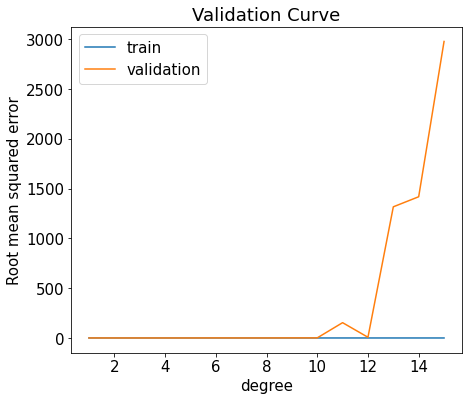

In [13]:
mean_train_score = -GS.cv_results_['mean_train_score']
mean_test_score = -GS.cv_results_['mean_test_score']

std_train_score = GS.cv_results_['std_train_score']
std_test_score = GS.cv_results_['std_train_score']

plt.plot(degree, mean_train_score, label = 'train')
plt.plot(degree, mean_test_score, label = 'validation')
plt.fill_between(degree, mean_train_score + std_train_score, mean_train_score - std_train_score )
plt.fill_between(degree, mean_test_score + std_test_score, mean_test_score - std_test_score )
print('Even if not visible, Im filling the space between (train+std, train-std)')

plt.title('Validation Curve')
plt.xlabel('degree')
plt.ylabel('Root mean squared error')
plt.legend()
plt.show()

For high-order degree of the polynomial, the cross-validation error becomes larger, telling us these models have a huge variance and they are overfitting the data.

Sklearn provides a tool to plot Validation Curve, an import distinction with the plot before is that now we are looking at negative root mean squared error.

Text(0.5, 1.0, 'Validation Curve')

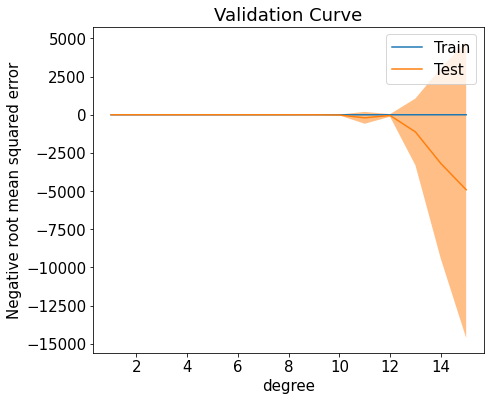

In [14]:
from sklearn.model_selection import ValidationCurveDisplay

ValidationCurveDisplay.from_estimator(PolynomialRegression(), z_sample[:, None], mu_sample, param_name='degree', 
param_range = degree, scoring= 'neg_root_mean_squared_error')
plt.title('Validation Curve')

In the end we plot the **Learning Curves**. We do that in order to check if the number of point in the dataset are enough. 

As before we use a sklearn tool.

Text(0.5, 1.0, 'Learning Curve')

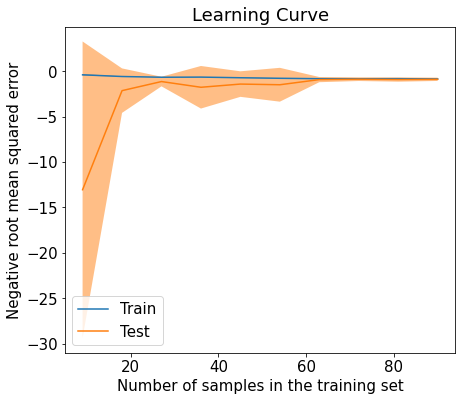

In [15]:
from sklearn.model_selection import  LearningCurveDisplay
LearningCurveDisplay.from_estimator(PolynomialRegression(degree = 5), z_sample[:, None], mu_sample, train_sizes = np.linspace(0.1,1, 10),
                                      cv = K, scoring= 'neg_root_mean_squared_error')
plt.title('Learning Curve')

We can conclude we are satisfied by the number of points in the dataset.

## Basis Function Regression


Considering a function in terms of a sum over bases we can solve for the linear amplitude coefficients using regression. It's still a linear regression.

We use gaussian bases but also we want to see the optimal number of bases using cross validation and looking at Validation Curves.

For this cross validation we devide our data into 70% training set and 30% validation set.

(35.0, 50.0)

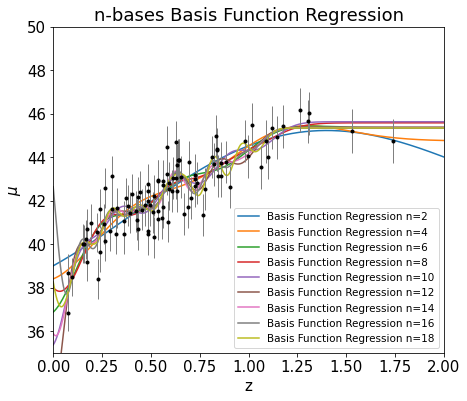

In [16]:
from astroML.linear_model import BasisFunctionRegression
from sklearn.model_selection import train_test_split

X_train, X_validation, ydy_train, ydy_validation = train_test_split(z_sample[:,np.newaxis], np.array([mu_sample,dmu]).T, test_size=0.3, random_state=1)
y_train,dy_train = ydy_train.T
y_validation,dy_validation = ydy_validation.T

n_bases = np.arange(2,20,2)


training_err = []
crossval_err = []

for i in n_bases:
    mu = np.linspace(0,1,i)[:, None]
    sigma = 1.0 * (mu[1] - mu[0])
    regressor = BasisFunctionRegression('gaussian', mu = mu, sigma=sigma)
    regressor.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    mu_fit = regressor.predict(z_grid[:,np.newaxis])
    plt.plot(z_grid, mu_fit,label='Basis Function Regression n='+str(i))
    
    p = regressor.fit(X_train, y_train, dy_train)
    training_err.append( np.sqrt(np.sum((y_train-regressor.predict(X_train)) ** 2)/ len(X_train)))
    crossval_err.append(np.sqrt(np.sum((y_validation-regressor.predict(X_validation)) ** 2)/ len(X_validation)))


    
training_err = np.array(training_err)
crossval_err = np.array(crossval_err)  
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right', fontsize = 'x-small')
plt.title('n-bases Basis Function Regression')
plt.xlim(0,2)
plt.ylim(35,50)

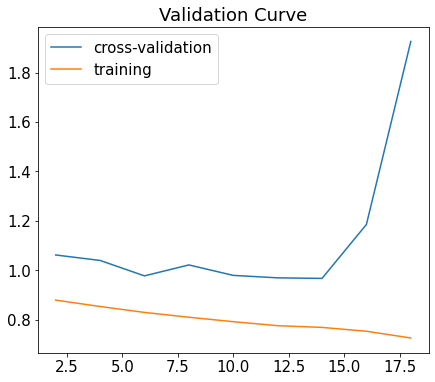

In [17]:
plt.plot(n_bases , crossval_err, label='cross-validation')
plt.plot(n_bases , training_err, label='training')
plt.title('Validation Curve')
plt.legend()

## Kernel Regression / Nadaraya-Watson Regression

In this kind of regression we set a kernel at each point.
It's a locally weighted regression technique that drives the regressed value to the nearest neighbor which helps with extrapolation issues. 
The correct bandwidth is more crucial than the kernel used, we resort to Cross-Validation to determine the optimal bandwidth.


[0.01       0.03111111 0.05222222 0.07333333 0.09444444 0.11555556
 0.13666667 0.15777778 0.17888889 0.2       ]


(35.0, 50.0)

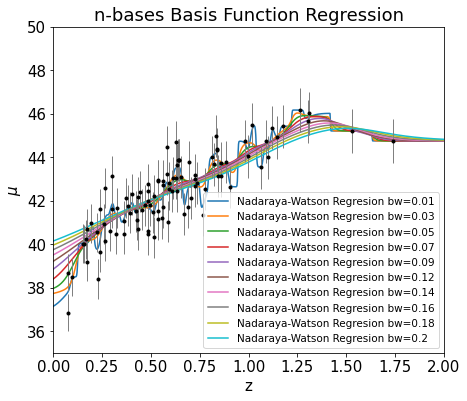

In [38]:
from astroML.linear_model import NadarayaWatson

h_range = np.linspace(0.01,0.2, 10) #h= bandwidth
print(h_range)

training_err_NW = []
crossval_err_NW = []

for i in h_range:
    
    regressor = NadarayaWatson('gaussian', i)
    regressor.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    mu_fit = regressor.predict(z_grid[:,np.newaxis])
    plt.plot(z_grid, mu_fit,label='Nadaraya-Watson Regresion bw='+str(round(i,2)))
    
    p = regressor.fit(X_train, y_train, dy_train)
    training_err_NW.append( np.sqrt(np.sum((y_train-regressor.predict(X_train)) ** 2)/ len(X_train)))
    crossval_err_NW.append(np.sqrt(np.sum((y_validation-regressor.predict(X_validation)) ** 2)/ len(X_validation)))


    
training_err_NW = np.array(training_err_NW)
crossval_err_NW = np.array(crossval_err_NW)  
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right', fontsize = 'x-small')
plt.title('n-bases Basis Function Regression')
plt.xlim(0,2)
plt.ylim(35,50)

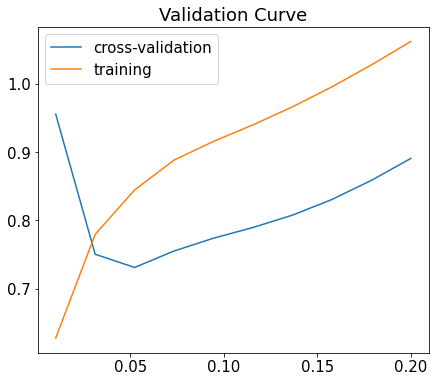

In [37]:
plt.plot(h_range , crossval_err_NW, label='cross-validation')
plt.plot(h_range , training_err_NW, label='training')
plt.title('Validation Curve')
plt.legend()

## Learning Curves as function of datapoints number

SE hai tempo puoi aggiustare la visualizzazioen

Text(0.5, 1.0, 'Learning Curve')

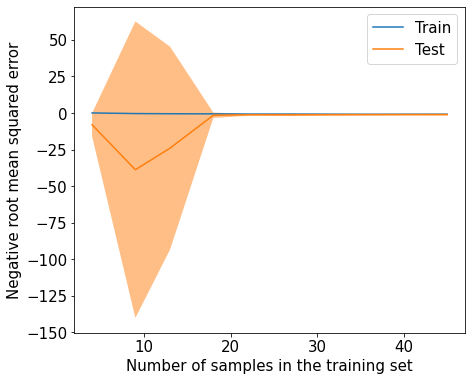

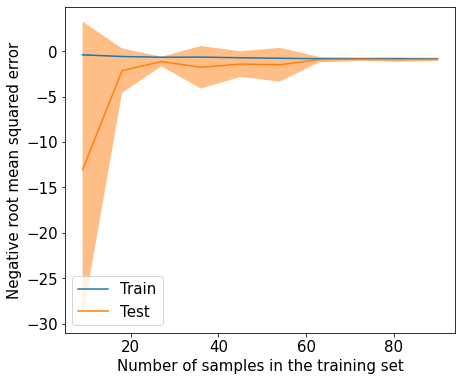

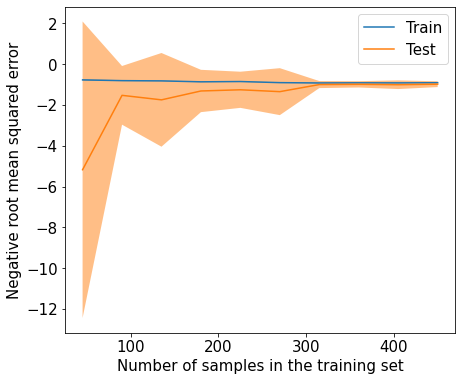

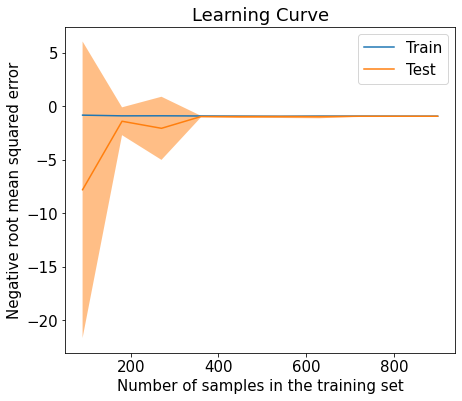

In [47]:
N = [50,100,500,1000]

for i in N:
    z_sample, mu_sample, dmu = generate_mu_z(i, random_state=1234)
    LearningCurveDisplay.from_estimator(PolynomialRegression(degree = optimal_n), z_sample[:, None], mu_sample, train_sizes = np.linspace(0.1,1, 10),cv = K, scoring= 'neg_root_mean_squared_error')
plt.title('Learning Curve')

